In [1]:
# importons les librairies dont nous avons besoin.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
%matplotlib inline
import math
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import pickle
import csv

In [2]:
data = pd.read_csv("clean_all_data.csv")
data = data.drop(columns=["TAIL_NUM"])
save = data

Comme vu dans le Baseline error finale (3) nos RMSE étaient de 36.50 et de 36.31 avec mean encoding et modèle unique sur l'ensemble du dataset. Voyons s'il est possible d'améliorer ces résultats en créant un modèle par compagnie aérienne.

# Un modèle par compagnie aérienne

Commençons par visualiser le nombre de ligne par compagnie aérienne. Cela sera sûrement à prendre en compte dans le choix de nos algorithmes finaux. En même temps, préparons notre dataset pour le mean encoding.

In [3]:
shapes = []
airlines = data["AIRLINE_ID"].unique()
columns = data.loc[:, "MONTH":"DAY_OF_WEEK"].columns
airlines_data = []

for airline in airlines:
    airline_data = data[data["AIRLINE_ID"] == airline]
    airline_data = airline_data.drop(columns=["AIRLINE_ID", "FL_NUM", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"], axis=1)
    airline_data.is_copy = False
    train, test = train_test_split(airline_data, test_size=0.2, random_state=0)
    for column in columns:
        items = train.groupby(column).mean()["ARR_DELAY_NEW"].round(2).to_dict()
        for key, value in items.items():
            airline_data.loc[airline_data[column] == key, column] = value
    airlines_data.append(airline_data)
    shapes.append(airline_data.shape[0])
            
for i in range(0, len(shapes)):
    print("The shape of airline %s is %s"% (airlines[i], shapes[i]))

The shape of airline 19805 is 873209
The shape of airline 19930 is 165641
The shape of airline 20409 is 280251
The shape of airline 19790 is 964797
The shape of airline 20436 is 94505
The shape of airline 19690 is 76334
The shape of airline 20416 is 135371
The shape of airline 20366 is 489510
The shape of airline 20304 is 593938
The shape of airline 19977 is 538190
The shape of airline 21171 is 66500
The shape of airline 19393 is 1277949


Les dummies risquent de prendre beaucoup de temps pour les compagnies 19805, 19790, 20366, 20304, 19977 et 19393.

## Mean encoding

Nous allons dans un premier temps utiliser la technique du mean encoding et nous testerons ensuite les dummies.

### Modèle 1 : Régression linéaire avec mean encoding
### Modèle 2 : Régression polynomiale de degré 2 avec mean encoding
### Modèle 3 : Régression polynomiale de degré 3 avec mean encoding

Afin d'optimiser notre notebook comparons ces 3 algorithmes en même temps. Toutefois, la régression polynomiale de degré 3 étant longue à faire tourner, nous ne la testerons que sur les compagnies aériennes les moins fournies.

In [4]:
errors = []
i = 0

for airline_data in airlines_data:
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    for regr in [LinearRegression(), make_pipeline(PolynomialFeatures(2), linear_model.Ridge())]:
        regr.fit(xtrain, ytrain)
        ypred = regr.predict(xtest)
        errors.append(math.sqrt(mean_squared_error(ytest, ypred)))
        print("Mean squared error: %.2f for %s with %s" % (math.sqrt(mean_squared_error(ytest, ypred)), airlines[i], str(regr).split("(")[0].replace("Pipeline", "Polynomiale 2")))
    i += 1
    
sum = 0
for i in range(0, len(shapes)):
    sum += shapes[i] * errors[2*i]
sum /= data.shape[0]
print("Final Mean squared error for LinearRegression: %.2f"% sum)

sum = 0
for i in range(0, len(shapes)):
    sum += shapes[i] * errors[2*i+1]
sum /= data.shape[0]
print("Final Mean squared error: %.2f for Polynomiale 2"% sum)

i = 0
for j in [1, 2, 4, 5, 6, 10]:
    airline_data = airlines_data[j]
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = make_pipeline(PolynomialFeatures(3), linear_model.Ridge())
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    errors.append(math.sqrt(mean_squared_error(ytest, ypred)))
    print("Mean squared error: %.2f for %s with Polynomiale 3" % (math.sqrt(mean_squared_error(ytest, ypred)), airlines[j]))
    i += 1

Mean squared error: 39.30 for 19805 with LinearRegression
Mean squared error: 39.05 for 19805 with Polynomiale 2
Mean squared error: 21.79 for 19930 with LinearRegression
Mean squared error: 21.49 for 19930 with Polynomiale 2
Mean squared error: 37.63 for 20409 with LinearRegression
Mean squared error: 36.52 for 20409 with Polynomiale 2
Mean squared error: 36.32 for 19790 with LinearRegression
Mean squared error: 35.69 for 19790 with Polynomiale 2
Mean squared error: 42.64 for 20436 with LinearRegression
Mean squared error: 42.28 for 20436 with Polynomiale 2
Mean squared error: 21.24 for 19690 with LinearRegression
Mean squared error: 21.21 for 19690 with Polynomiale 2
Mean squared error: 40.62 for 20416 with LinearRegression
Mean squared error: 40.30 for 20416 with Polynomiale 2
Mean squared error: 44.63 for 20366 with LinearRegression
Mean squared error: 44.49 for 20366 with Polynomiale 2
Mean squared error: 42.46 for 20304 with LinearRegression
Mean squared error: 42.29 for 20304 wi

Les résultats sont meilleurs que ceux obtenus avec la baseline error ce qui confirme notre choix de créer un modèle par compagnie. 

Il est à noter que les régressions polinomiales performent mieux que la régression linéaire. 

Enfin, si la régression polynomiale de degré 3 est parfois plus intéressante que celle de degré 2, elle semble moins robuste et est plus longue à exécuter, nous préférerons donc la régression polynomiale de degré 2.

### Modèle 4 : Régression linéaire avec dummies (sans FL_NUM)

La conversion de la colonne FL_NUM en dummies engendrant un trop grand nombre de colonnes, décidons de ne pas utiliser cette colonne dans un premier temps sur l'ensemble des compagnies aériennes.

In [5]:
columns = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH"]
airlines_data = []

for airline in airlines:
    airline_data = data[data["AIRLINE_ID"] == airline]
    airline_data = airline_data.drop(columns=["AIRLINE_ID"], axis=1)
    airline_data = pd.get_dummies(airline_data, columns=columns)
    airlines_data.append(airline_data)

In [6]:
errors = []
i = 0

for airline_data in airlines_data:
    airline_data = airline_data.drop(columns=["FL_NUM"], axis=1)
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    errors.append(math.sqrt(mean_squared_error(ytest, ypred)))
    print("Mean squared error: %.2f for %d" % (math.sqrt(mean_squared_error(ytest, ypred)), airlines[i]))
    i += 1
    
sum = 0
for i in range(0, len(shapes)):
    sum += shapes[i] * errors[i]
sum /= data.shape[0]
print("Final Mean squared error: %.2f"% sum)

Mean squared error: 39.18 for 19805
Mean squared error: 21.61 for 19930
Mean squared error: 37.13 for 20409
Mean squared error: 36.14 for 19790
Mean squared error: 42.44 for 20436
Mean squared error: 21.22 for 19690
Mean squared error: 39.97 for 20416
Mean squared error: 52.22 for 20366
Mean squared error: 42.17 for 20304
Mean squared error: 37.14 for 19977
Mean squared error: 28.78 for 21171
Mean squared error: 24.91 for 19393
Final Mean squared error: 35.72


Les résultats sont ici moins bons qu'avec la regression polynomiale de degré 2.

### Modèle 5 : Régression linéaire avec dummies (avec FL_NUM)

Décidons désormais de prendre en compte les FL_NUM afin de voir si l'on peut améliorer les résultats. Mais afin de ne pas alonger de façon considérable les délais, testons cette approche uniquement sur les compagnies les moins fournies en données.

In [7]:
airlines_dummies = [19930, 20409, 20436, 19690, 20416, 21171]
shapes_dummies = [165641, 280251, 94505, 76334, 135371, 66500]
airlines_data_dummies = []
dummies = [1, 2, 4, 5, 6, 10]

for i in range(0, 12):
    if i in dummies:
        airlines_data_dummies.append(airlines_data[i])

airlines_data = []

for airline_data in airlines_data_dummies:
    airline_data = pd.get_dummies(airline_data, columns=["FL_NUM"])
    airlines_data.append(airline_data)

In [8]:
errors = []
i = 0

for airline_data in airlines_data:
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    errors.append(math.sqrt(mean_squared_error(ytest, ypred)))
    print("Mean squared error: %.2f for %d" % (math.sqrt(mean_squared_error(ytest, ypred)), airlines_dummies[i]))
    i += 1

sum = 0
for i in range(0, len(shapes_dummies)):
    sum += shapes_dummies[i] * errors[i]
sum /= data.shape[0]
print("Final Mean squared error: %.2f"% sum)

Mean squared error: 19.57 for 19930
Mean squared error: 34.67 for 20409
Mean squared error: 119349355.22 for 20436
Mean squared error: 20.59 for 19690
Mean squared error: 49491.79 for 20416
Mean squared error: 22.81 for 21171
Final Mean squared error: 2031215.00


Les résultats se sont améliorés pour certaines de nos compganies aérinnes. On obtient au final comme meilleurs résultats :

- Mean squared error: 39.05 for 19805 with Polynomiale 2
- Mean squared error: 19.57 for 19930 with Dummies
- Mean squared error: 34.67 for 20409 with Dummies
- Mean squared error: 35.69 for 19790 with Polynomiale 2
- Mean squared error: 42.28 for 20436 with Polynomiale 2
- Mean squared error: 20.59 for 19690 with Dummies
- Mean squared error: 40.30 for 20416 with Polynomiale 2
- Mean squared error: 44.49 for 20366 with Polynomiale 2
- Mean squared error: 42.29 for 20304 with Polynomiale 2
- Mean squared error: 37.06 for 19977 with Polynomiale 2
- Mean squared error: 28.41 for 21171 with Dummies
- Mean squared error: 24.56 for 19393 with Polynomiale 2
- Final Mean squared error: 34.67

Soit un écart de 34 minutes et 40.2 secondes. Ces résultats sont donc meilleurs que ceux obtenus avec notre baseline error.

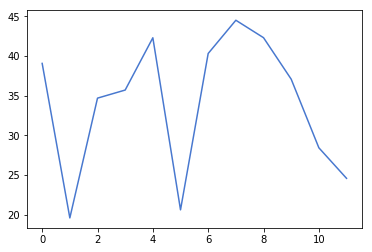

In [9]:
best_errors = {19805: 39.05, 19930: 19.57, 20409: 34.67, 19790: 35.69, 20436: 42.28, 19690: 20.59, 20416: 40.30, 20366: 44.49, 20304: 42.29, 19977: 37.06, 21171: 28.41, 19393: 24.56}
plt.plot(best_errors.values())

Avant d'enregister les CSV dont nous avons besoin, regardons ce que notre polynomiale de degré 2 donne lorsque l'on élimine les valeurs extrêmes de notre dataset. Nous éliminerons pour chaque compagnie aérienne les vols ayant un retard supérieur à 99% des autres.

In [10]:
data = pd.read_csv("clean_all_data.csv")
data = data.drop(columns=["TAIL_NUM"])
airlines = data["AIRLINE_ID"].unique()
columns = data.loc[:, "MONTH":"DAY_OF_WEEK"].columns
airlines_data = []

for airline in airlines:
    airline_data = data[data["AIRLINE_ID"] == airline]
    airline_data = airline_data[airline_data["ARR_DELAY_NEW"] < airline_data["ARR_DELAY_NEW"].quantile(.99)]
    airline_data = airline_data.drop(columns=["AIRLINE_ID", "FL_NUM", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"], axis=1)
    airline_data.is_copy = False
    train, test = train_test_split(airline_data, test_size=0.2, random_state=0)
    for column in columns:
        items = train.groupby(column).mean()["ARR_DELAY_NEW"].round(2).to_dict()
        for key, value in items.items():
            airline_data.loc[airline_data[column] == key, column] = value
    airlines_data.append(airline_data)
            

errors = []
i = 0

for airline_data in airlines_data:
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = make_pipeline(PolynomialFeatures(2), linear_model.Ridge())
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    errors.append(math.sqrt(mean_squared_error(ytest, ypred)))
    print("Mean squared error: %.2f for %s" % (math.sqrt(mean_squared_error(ytest, ypred)), airlines[i]))
    i += 1
    
sum = 0
for i in range(0, len(shapes)):
    sum += shapes[i] * errors[i]
sum /= data.shape[0]
print("Final Mean squared error: %.2f for Polynomiale 2"% sum)

Mean squared error: 22.74 for 19805
Mean squared error: 13.05 for 19930
Mean squared error: 27.23 for 20409
Mean squared error: 19.05 for 19790
Mean squared error: 28.79 for 20436
Mean squared error: 7.30 for 19690
Mean squared error: 27.38 for 20416
Mean squared error: 26.59 for 20366
Mean squared error: 23.98 for 20304
Mean squared error: 24.65 for 19977
Mean squared error: 23.34 for 21171
Mean squared error: 17.56 for 19393
Final Mean squared error: 21.51 for Polynomiale 2


On remarque ici que les prédictions se sont largement améliorés. Bien évidemment ces résultats sont biaisés puisque des valeurs du dataset de test ont été supprimées, mais on peut se rendre compte que si notre algorithme ne devait prevoir que les faibles retards il serait également intéressant.

## Sauvegarde des coefficients

### Polynomiale 2 avec mean encoding

In [72]:
data = pd.read_csv("clean_all_data.csv")
data = data.drop(columns=["TAIL_NUM"])
airlines = [19805, 19790, 20436, 20416, 20366, 20304, 19977, 19393]
columns = data.loc[:, "MONTH":"DAY_OF_WEEK"].columns
airlines_data = []

for airline in airlines:
    airline_data = data[data["AIRLINE_ID"] == airline]
    airline_data = airline_data.drop(columns=["AIRLINE_ID", "FL_NUM", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"], axis=1)
    airline_data.is_copy = False
    train, test = train_test_split(airline_data, test_size=0.2, random_state=0)
    for column in columns:
        items = train.groupby(column).mean()["ARR_DELAY_NEW"].round(2).to_dict()
        with open('airlines/{}/{}.csv'.format(airline, column.lower()), 'w') as csv_file:
            writer = csv.writer(csv_file)
            for key, value in items.items():
                writer.writerow([key, value])
                airline_data.loc[airline_data[column] == key, column] = value
    airlines_data.append(airline_data)

errors = []
i = 0

for airline_data in airlines_data:
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = make_pipeline(PolynomialFeatures(2), linear_model.Ridge())
    regr.fit(xtrain, ytrain)
    filename = 'airlines/{}/model.sav'.format(airlines[i])
    pickle.dump(regr, open(filename, 'wb'))
    i += 1

## Régression linéaire avec dummies

In [168]:
columns = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH", "FL_NUM"]
data = pd.read_csv("clean_all_data.csv")
data = data.drop(columns=["TAIL_NUM"])
airlines = [19930, 20409, 19690, 21171]
airlines_data = []

for airline in airlines:
    airline_data = data[data["AIRLINE_ID"] == airline]
    airline_data = airline_data.drop(columns=["AIRLINE_ID"], axis=1)
    airline_data = pd.get_dummies(airline_data, columns=columns)
    list(xtest.columns)
    with open('airlines/{}/{}.csv'.format(airline, "columns"), 'w') as csv_file:
        writer = csv.writer(csv_file)
        columns_to_save = list(airline_data.columns)
        columns_to_save.remove("ARR_DELAY_NEW")
        writer.writerow(columns_to_save)
    airlines_data.append(airline_data)
    
errors = []
i = 0

for airline_data in airlines_data:
    xtrain, xtest, ytrain, ytest = train_test_split(airline_data.loc[:, airline_data.columns != 'ARR_DELAY_NEW'], airline_data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = LinearRegression()
    regr.fit(xtrain, ytrain)
    filename = 'airlines/{}/model.sav'.format(airlines[i])
    pickle.dump(regr, open(filename, 'wb'))
    i += 1